Connect kaggle for dataset

In [1]:
from google.colab import files
uploaded = files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Jul  5 06:58 kaggle.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 6.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=e69e3af9f6b9fb3aa38a6b01a1a8ab48e8452b0fdb9d14392925a069d3de906e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Download the dataset from kaggle using the URL of the kaggle page

In [2]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 82% 28.0M/34.1M [00:00<00:00, 153MB/s]
100% 34.1M/34.1M [00:00<00:00, 157MB/s]


unzip the dataset

In [3]:
!unzip alzheimers-dataset-4-class-of-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

Import the libraries 

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import os
import time
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array,load_img
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math

makes the cloud memory works faster.

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
  
print(tf.__version__)

Number of replicas: 1
2.8.2


batch size

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
EPOCHS = 5
print(BATCH_SIZE)

16


prepare the datset int the tenserflow format

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


class names is assigned

In [8]:
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(class_names)
NUm_CLASSES = len(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


visualize the training dataset
take(1): means batch 1

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


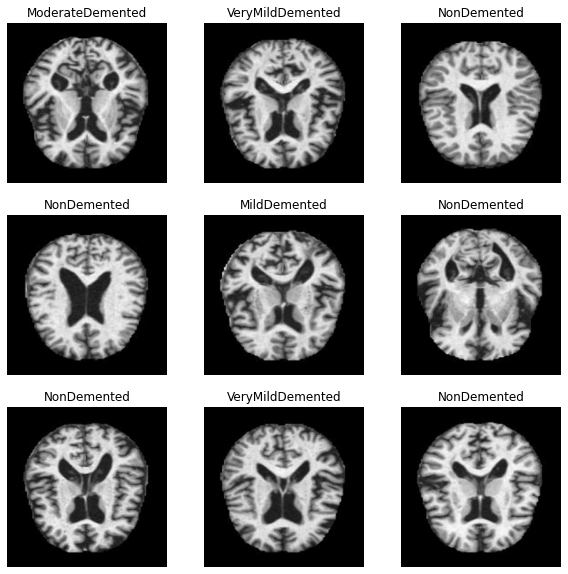

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")
    print(images[i].numpy().shape)

converting to numerical representation .i.e. one hot level

In [10]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

Clear the cache for making the code run faster

In [11]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Visualize number of images in class

In [12]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [13]:
NUM_IMAGES

[717, 52, 2560, 1792]

Visualixe it as a bar graph

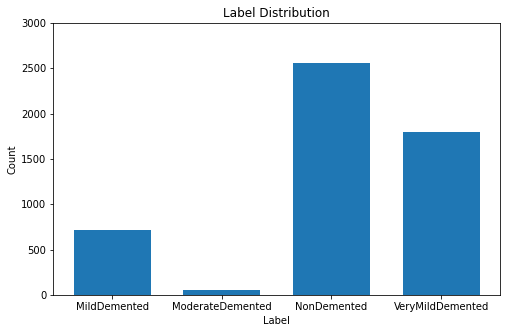

In [14]:
fig = plt.figure(figsize=(8, 5))
plt.bar(class_names, NUM_IMAGES, width=0.7, align='center')
plt.title("Label Distribution")
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(class_names)
plt.ylim(0, 3000)
# for a, b in zip(class_names, NUM_CLASSES):
#     plt.text(a, b, '%d' % b, ha='center', va='bottom', fontsize=10)
plt.show()

**Model Preparation**

imorting the lib

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

Creating a convolutional layer

In [16]:
model_normal= tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4,  activation=tf.nn.softmax)
])

Compiling, tratining and evaluatiing the model.

In [17]:
model_normal.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model_normal.fit(train_ds, batch_size=32, epochs=20, verbose=1,validation_data=val_ds)
score = model_normal.evaluate(val_ds, batch_size=100, verbose=10 )
print("Test Score: ", score[0])
print("Test accuracy: ", score[1])

257/257 [==============================] - 29s 67ms/step - loss: 10.9326 - accuracy: 0.4872 - val_loss: 1.0482 - val_accuracy: 0.4648
Epoch 2/20
257/257 [==============================] - 16s 62ms/step - loss: 1.0661 - accuracy: 0.4967 - val_loss: 1.1017 - val_accuracy: 0.4697
Epoch 3/20
257/257 [==============================] - 16s 62ms/step - loss: 2.1378 - accuracy: 0.5016 - val_loss: 1.0590 - val_accuracy: 0.4707
Epoch 4/20
257/257 [==============================] - 16s 62ms/step - loss: 1.0630 - accuracy: 0.5009 - val_loss: 1.0313 - val_accuracy: 0.4902
Epoch 5/20
257/257 [==============================] - 16s 62ms/step - loss: 1.4854 - accuracy: 0.5175 - val_loss: 5.6677 - val_accuracy: 0.1475
Epoch 6/20
257/257 [==============================] - 16s 62ms/step - loss: 1.0383 - accuracy: 0.5260 - val_loss: 1.0810 - val_accuracy: 0.4854
Epoch 7/20
257/257 [==============================] - 16s 62ms/step - loss: 1.1911 - accuracy: 0.5399 - val_loss: 1.0256 - val_accuracy: 0.4951
Ep

Using the VGG16 model

In [ ]:
num_classes = 4
#input shape
input_layer = Input(shape=(224, 224, 3))

#Use the VGG16 model 
model = VGG16(input_tensor=input_layer, include_top=True,weights='imagenet')

#Summary of the customize VGG16 model
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

customizing the vgg model and USing transfer learning

In [ ]:
last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(input_layer, out)
custom_vgg_model.summary()
#Transfer learning
for layer in custom_vgg_model.layers[:-1]:
    layer.trainable = False

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
hist=custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
hist = custom_vgg_model.fit(train_ds, batch_size=32, epochs=20, verbose=1,validation_data=val_ds)

Epoch 1/20
257/257 [==============================] - 26s 101ms/step - loss: 1.1393 - accuracy: 0.5746 - val_loss: 3.1243 - val_accuracy: 0.3564
Epoch 2/20
257/257 [==============================] - 26s 102ms/step - loss: 1.0517 - accuracy: 0.6002 - val_loss: 2.9859 - val_accuracy: 0.3633
Epoch 3/20
257/257 [==============================] - 26s 101ms/step - loss: 0.9803 - accuracy: 0.6256 - val_loss: 2.8717 - val_accuracy: 0.3711
Epoch 4/20
257/257 [==============================] - 26s 102ms/step - loss: 0.9190 - accuracy: 0.6454 - val_loss: 2.7706 - val_accuracy: 0.3779
Epoch 5/20
257/257 [==============================] - 26s 101ms/step - loss: 0.8709 - accuracy: 0.6676 - val_loss: 2.6161 - val_accuracy: 0.3945
Epoch 6/20
257/257 [==============================] - 26s 101ms/step - loss: 0.8267 - accuracy: 0.6878 - val_loss: 2.5032 - val_accuracy: 0.4053
Epoch 7/20
257/257 [==============================] - 26s 102ms/step - loss: 0.7888 - accuracy: 0.7010 - val_loss: 2.3830 - val_ac

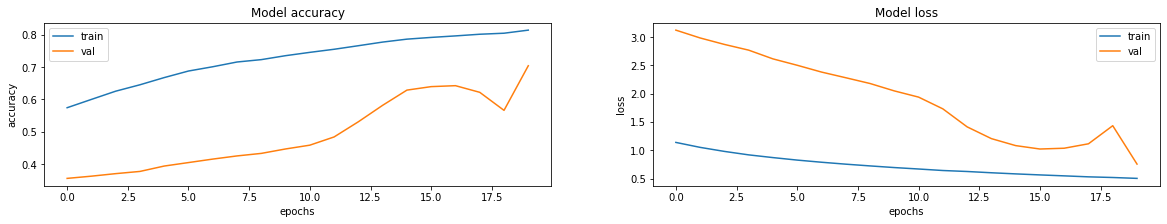

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
y_predicts = custom_vgg_model.predict(val_ds)
print(y_predicts)
y_predicts.shape

[[2.36277670e-01 1.05248662e-02 2.16589831e-02 7.31538534e-01]
 [9.86024678e-01 1.02823816e-13 1.03979219e-04 1.38713624e-02]
 [1.31715686e-04 3.91788079e-21 2.45755780e-02 9.75292742e-01]
 ...
 [2.16432862e-04 8.02649031e-14 8.29815626e-01 1.69967860e-01]
 [6.19658828e-01 4.09784186e-13 1.01807274e-01 2.78533936e-01]
 [1.31060993e-02 6.52514916e-32 7.21797585e-01 2.65096277e-01]]


(1024, 4)

In [ ]:
def decoder(val):
  class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
  return class_names[val]

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


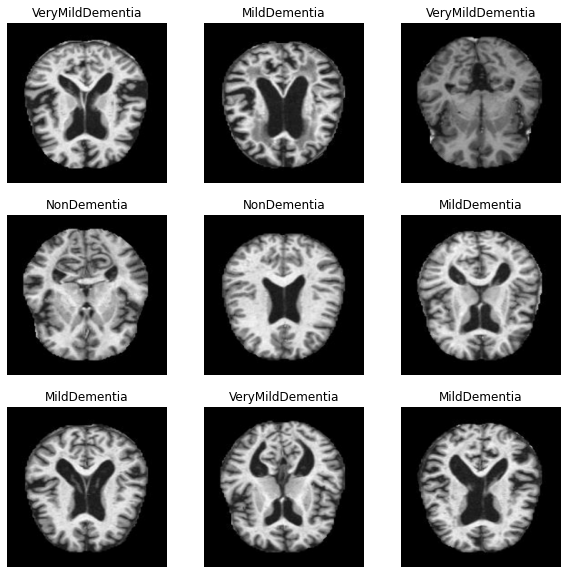

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(decoder(np.argmax(y_predicts[i])))
    plt.axis("off")
    print(images[i].numpy().shape)

Testing on images from unseen dataset

NonDementia


(-0.5, 223.5, 223.5, -0.5)

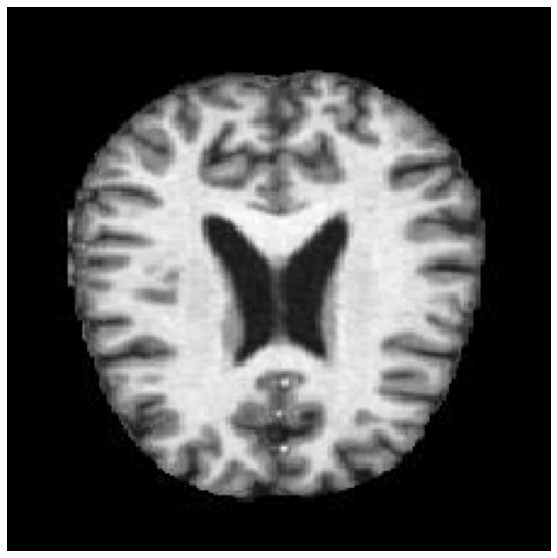

In [ ]:
images = image.load_img("Alzheimer_s Dataset/test/NonDemented/26 (100).jpg", target_size=( 224, 224))    
x = image.img_to_array(images)
x = x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
prediction=custom_vgg_model.predict(x)
print(decoder(np.argmax(prediction)))
plt.figure(figsize=(10, 10))
plt.imshow(x[0].astype("uint8"))
plt.axis("off")

Accuracy generation

In [ ]:
(loss, accuracy) = custom_vgg_model.evaluate(val_ds, batch_size=100, verbose=10)

In [ ]:
accuracy

0.7041015625

Saving the model

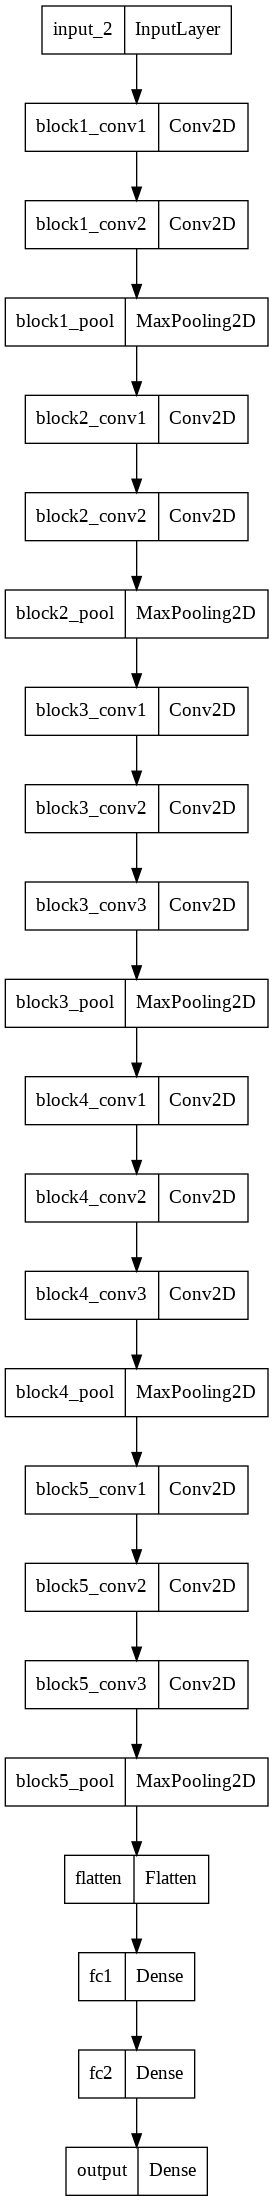

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(custom_vgg_model,to_file = 'plot.png')

In [ ]:
from tensorflow.keras.models import Model
from keras import  models
# ResNet as Feature Extractor
inputTensor = Input(shape=(224,224,3,))
resnet=tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputTensor,pooling=None)
F=resnet.layers[-1].output